<a href="https://colab.research.google.com/github/WexyR/IML_Terminator/blob/main/NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook info

In [ ]:
import tensorflow as tf
import keras

#from tensorflow.keras import layers
from keras.layers import *
from keras import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import collections

#network
import requests, io

print(tf.__version__)
print(keras.__version__)

2.3.0
2.4.3


In [ ]:
r = requests.get("https://github.com/WexyR/IML_Terminator/blob/main/resources/datasets/sample_dataset_0-4999.npz?raw=true") 
bytecontent1 = io.BytesIO(r.content)
r = requests.get("https://github.com/WexyR/IML_Terminator/blob/main/resources/datasets/sample_dataset_5000-9999.npz?raw=true") 
bytecontent2 = io.BytesIO(r.content)
dataset1 = np.load(bytecontent1)
dataset2 = np.load(bytecontent2)

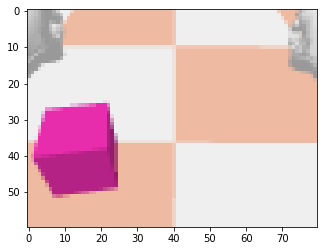

64th element of the database is:
sensors:[0.7026 0.6865 0.675  0.8716 3.     3.     3.     3.     3.     3.
 3.     3.     3.     3.     3.    ]
y: 7
Labels are : ['MAROON' 'RED' 'ORANGE' 'YELLOW' 'OLIVE' 'GREEN' 'PURPLE' 'FUSHIA' 'LIME'
 'TEAL' 'AQUA' 'BLUE' 'NAVY' 'BLACK' 'GRAY' 'SILVER' 'WHITE']
there are 10000 data


In [ ]:
X = np.asarray(list(zip(dataset1['img'], dataset1['sensors'])) + list(zip(dataset2['img'], dataset2['sensors'])))
# print(X.shape, X[0][0].shape, X[0][1].shape)
y = np.asarray(list(dataset1['class_id']) + list(dataset2['class_id']))



image_shape = X[0][0].shape
sensors_shape = X[0][1].shape
class_names = dataset["labels"]
class_outputs = class_names.size
ELEMENT_NTH = 64
plt.imshow(X[ELEMENT_NTH][0])
plt.show()
print(f"{ELEMENT_NTH}th element of the database is:\nsensors:{X[ELEMENT_NTH][1]}\ny: {y[ELEMENT_NTH]}\n"
      f"Labels are : {class_names}")
print(f"there are {len(y)} data")

In [ ]:
#IML utils

def balance_data(X, y):
    c = collections.Counter(y)
    mini = min(c.values())
    print(mini)
    d = collections.defaultdict(lambda:0)
    outX, outy = list(), list()
    for inX, iny in zip(X, y):
        if(d[iny]<mini):
            outX.append(inX)
            outy.append(iny)
            d[iny]+=1
    return outX, outy

def data_split(X, y, ratio, **kwargs):
    """Split a dataset (X, inputs), (y, outputs) following the ratio parameter with a shuffle
    it uses the train_test_split function which can receive parameters
        (but train_size and test_size) through **kwargs
    """
    if(not isinstance(ratio, collections.abc.Iterable)):
        ratio=[ratio]
    else:
        ratio=list(ratio)
    assert len(ratio)>=1
    assert "train_size" not in kwargs
    assert "test_size" not in kwargs
    while sum(ratio) >= 1:
        ratio.pop()
    if(len(ratio)==1):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=ratio[0], **kwargs)
        return [(np.asarray(X_train), np.asarray(y_train))] + [(np.asarray(X_test), np.array(y_test))]
    else:
        current_ratio = ratio.pop(0)
        ratio = [p/(1-current_ratio) for p in ratio]
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=current_ratio, **kwargs)
        return [(np.asarray(X_train), np.asarray(y_train))] + data_split(X_test, y_test, ratio, **kwargs)

In [ ]:
# X, y = balance_data(X, y)
# print(len(y))
trainset, validset, testset = data_split(X, y, ratio=(0.4, 0.3, 0.3))
# trainset[0][0]
print(len(y))

10000


In [ ]:
s_input = Input(shape=sensors_shape)
img_input = Input(shape=image_shape)

conv_img_input = Conv2D(32, 5, activation="relu")(img_input)
max_conv_img = MaxPool2D((4, 4))(conv_img_input)
# conv_max = Conv2D(32, 5, activation="relu")(max_conv_img)
# max_conv_max = MaxPool2D((2, 2))(conv_max)
flatten = Flatten()(max_conv_img)

sensor_dense = Dense(sensors_shape[0]//2)(s_input)

layer = Concatenate()([flatten, sensor_dense])
# for hl in (512, 32):
layer = Dense(512, activation="relu")(layer)
# layer = Dropout(0.2)(layer)
layer = Dense(32, activation="relu")(layer)
z = Dense(class_outputs, activation="softmax")(layer)

cnn = Model(inputs=[img_input, s_input], outputs=z)

cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

cnn.summary()

Model: "functional_101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_102 (InputLayer)          [(None, 60, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 56, 76, 32)   2432        input_102[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_65 (MaxPooling2D) (None, 14, 19, 32)   0           conv2d_65[0][0]                  
__________________________________________________________________________________________________
input_101 (InputLayer)          [(None, 15)]         0                                            
_____________________________________________________________________________________

In [ ]:
X_trainset_img = np.asarray(list(zip(*list(trainset[0])))[0])
X_trainset_sensors = np.asarray(list(zip(*list(trainset[0])))[1])
X_validset_img = np.asarray(list(zip(*list(validset[0])))[0])
X_validset_sensors = np.asarray(list(zip(*list(validset[0])))[1])
X_testset_img = np.asarray(list(zip(*list(testset[0])))[0])
X_testset_sensors = np.asarray(list(zip(*list(testset[0])))[1])

# print(X_trainset_img.shape)
# print(X_trainset_sensors.shape)
# print(X_validset_img.shape)
# print(X_validset_sensors.shape)
# print(X_testset_img.shape)
# print(X_testset_sensors.shape)

In [ ]:
history = cnn.fit([X_trainset_img, X_trainset_sensors], 
                  trainset[1],
                  validation_data=([X_validset_img, X_validset_sensors], validset[1]),
                  batch_size=75,
                    epochs=6)

predictions = cnn.predict([X_testset_img, X_testset_sensors])
cnn.evaluate([X_testset_img, X_testset_sensors],  testset[1], verbose=2)

Epoch 1/6
54/54 [==============================] - 18s 337ms/step - loss: 33.8116 - accuracy: 0.1647 - val_loss: 2.6043 - val_accuracy: 0.2640
Epoch 2/6
54/54 [==============================] - 18s 335ms/step - loss: 2.0560 - accuracy: 0.3862 - val_loss: 1.6451 - val_accuracy: 0.4600
Epoch 3/6
54/54 [==============================] - 18s 341ms/step - loss: 1.2800 - accuracy: 0.5585 - val_loss: 1.4641 - val_accuracy: 0.5117
Epoch 4/6
54/54 [==============================] - 18s 336ms/step - loss: 0.8671 - accuracy: 0.7072 - val_loss: 1.2949 - val_accuracy: 0.5860
Epoch 5/6
54/54 [==============================] - 18s 336ms/step - loss: 0.5544 - accuracy: 0.8190 - val_loss: 1.2886 - val_accuracy: 0.6013
Epoch 6/6
54/54 [==============================] - 18s 336ms/step - loss: 0.3536 - accuracy: 0.8835 - val_loss: 1.5467 - val_accuracy: 0.5803
94/94 - 4s - loss: 1.5343 - accuracy: 0.6010


[1.5342602729797363, 0.6010000109672546]

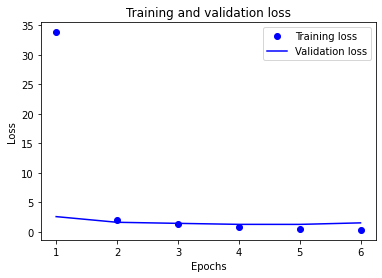

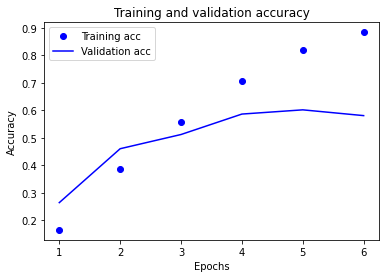

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[:,:,::-1])

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% (True: {})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(class_outputs))
  plt.yticks([])
  thisplot = plt.bar(range(class_outputs), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

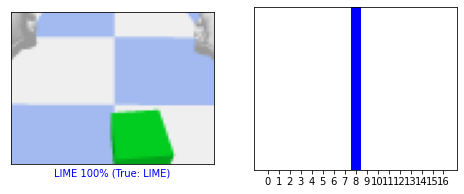

In [ ]:
i += 1
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], testset[1], X_testset_img)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  testset[1])
plt.show()